# Fitness Trends Dataset A dataset of fitness trends and how they change with exercise

## Parte 3: Corrida

[Fitness Trends Dataset A dataset of fitness trends and how they change with exercise](https://www.kaggle.com/aroojanwarkhan/fitness-data-trends/)

Clases para el STAN de [Liricus SRL](http://www.liricus.com.ar)

Dictado durante 3 clases en el primer semestre del 2019 por personal del [IATE-OAC-CONICET](http://iate.oac.uncor.edu/)

## Librerias a usar

In [1]:
# contador
import pickle

# computo numerico convencional
import numpy as np

# dataframes
import pandas as pd

# importamos plots
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

# mejor manejo de dataframes para plot
import seaborn as sns

# ML
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, roc_curve, auc

# fijamos el estado de random
np.random.seed(42)

# apagamos warnings
import warnings
warnings.filterwarnings("ignore")

from IPython.display import display, Markdown

In [2]:
import joblib
cpu = joblib.cpu_count()
print(cpu)

8


In [3]:
Xc = ["step_count", "mood", "calories_burned", "hours_of_sleep", "weight_kg"]
yc = "bool_of_active"

### Recreamos los datos

In [4]:
df = pd.read_pickle("out/scaled_df.pkl")

X = df[Xc].values
y = df[yc].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

### Recreamos los clasificadores

In [5]:
with open("out/best_results.pkl", "rb") as fp:
    bests = pickle.load(fp)

out = []
for clf, results in bests.items():
    out.append(f"#### {clf}")
    for score, best in results.items():
        out.append(f"- **{score}**: {best}")
    out.append("")

display(Markdown("\n".join(out)))

clfs = {
    "svc": SVC(probability=True, **bests["SVC"]["precision"]),
    "rf_p": RandomForestClassifier(**bests["RandomForestClassifier"]["precision"]),
    "rf_r": RandomForestClassifier(**bests["RandomForestClassifier"]["recall"]),
    "knn": KNeighborsClassifier(**bests["KNeighborsClassifier"]["precision"])}

#### SVC
- **precision**: {'C': 1, 'kernel': 'linear'}
- **recall**: {'C': 1, 'kernel': 'linear'}

#### RandomForestClassifier
- **precision**: {'criterion': 'entropy', 'max_features': 0.2, 'min_samples_split': 10, 'n_estimators': 500, 'n_jobs': 10}
- **recall**: {'criterion': 'entropy', 'max_features': 0.2, 'min_samples_split': 10, 'n_estimators': 500, 'n_jobs': 10}

#### KNeighborsClassifier
- **precision**: {'n_neighbors': 27, 'p': 2, 'weights': 'uniform'}
- **recall**: {'n_neighbors': 27, 'p': 2, 'weights': 'uniform'}


### Ejecutamos los clasificadores

In [6]:
for name, clf in clfs.items():
    print(f"Model {name}")
    clf.fit(X_train, y_train)
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print("-" * 40)

Model svc
              precision    recall  f1-score   support

           0       0.74      0.78      0.76        18
           1       0.60      0.55      0.57        11

    accuracy                           0.69        29
   macro avg       0.67      0.66      0.66        29
weighted avg       0.68      0.69      0.69        29

----------------------------------------
Model rf_p
              precision    recall  f1-score   support

           0       0.73      0.89      0.80        18
           1       0.71      0.45      0.56        11

    accuracy                           0.72        29
   macro avg       0.72      0.67      0.68        29
weighted avg       0.72      0.72      0.71        29

----------------------------------------
Model rf_r
              precision    recall  f1-score   support

           0       0.71      0.83      0.77        18
           1       0.62      0.45      0.53        11

    accuracy                           0.69        29
   macro avg  

### Curva ROC

(0, 1.01)

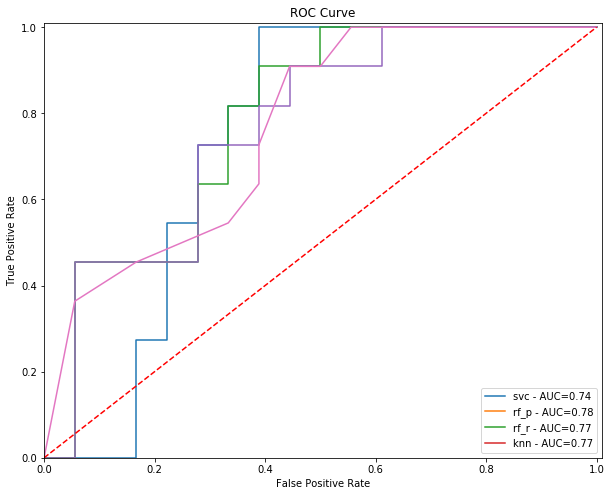

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))

plt.title("ROC Curve")

cmap = cm.get_cmap("viridis")
colors = iter(cmap(4))

legends = []
for name, clf in clfs.items():
    
    y_probas = clf.predict_proba(X_test)
       
    preds = y_probas[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, next(colors))
    legends.append(f'{name} - AUC={roc_auc:.2f}')

    
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate');    
ax.legend(legends, loc = 'lower right')

ax.plot([0, 1], [0, 1],'r--')
ax.set_xlim([0, 1.01])
ax.set_ylim([0, 1.01])


----

### Y como se usa?

supongamos que tenemos una observacion nueva

In [8]:
obs = [
    1000, # step count
    200, # mod regular
    10, # calories_burned
    7.5, # hours_of_sleep,
    70, # weight
]

#### 1. Se escala la observacion con los datos **DE ENTRENAMIENTO**

In [9]:
with open("out/scaler.pkl", "rb") as fp:
    scaler = pickle.load(fp)

In [10]:
obs = scaler.transform([obs])
obs

array([[0.13181019, 0.5       , 0.04115226, 0.78571429, 3.        ]])

#### 2. Se entrena con **TODO**

In [11]:
clf = RandomForestClassifier(**bests["RandomForestClassifier"]["precision"])
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=0.2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=10, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

#### 3. Se predice

In [12]:
clf.predict(obs)

array([0])

In [13]:
clf.predict_proba(obs)

array([[0.66826436, 0.33173564]])